Libraries

In [29]:
import shap
import xgboost as xgb
import joblib
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

Paths

In [2]:
model_path=Path.cwd().parent/"models"/"xgb_scaled_pos_model.pkl"
df_path=Path.cwd().parent/"data"/"processed_telco_churn.csv"

In [21]:
model=joblib.load(model_path)
df=pd.read_csv(df_path)


In [22]:
df.head()

,Gender,Senior Citizen,Partner,Dependents,tenure,Phone Service,Paperless Billing,MonthlyCharges,TotalCharges,Multiple Lines_No phone service_False,...,Contract_Two year_False,Contract_Two year_True,Payment Method_Credit card (automatic)_False,Payment Method_Credit card (automatic)_True,Payment Method_Electronic check_False,Payment Method_Electronic check_True,Payment Method_Mailed check_False,Payment Method_Mailed check_True,tenure_bucket,churn_label
0,1,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,...,1,0,1,0,1,0,0,1,0,1
1,0,0,0,1,-1.239504,1,1,0.196178,-0.940457,1,...,1,0,1,0,0,1,1,0,0,1
2,0,0,0,1,-0.995040,1,1,1.158489,-0.645369,1,...,1,0,1,0,0,1,1,0,0,1
3,0,0,1,1,-0.180161,1,1,1.329677,0.336516,1,...,1,0,1,0,0,1,1,0,2,1
4,1,0,0,1,0.675462,1,1,1.293113,1.214589,1,...,1,0,1,0,1,0,1,0,3,1


recreating X_test

In [23]:
#target is churn_label
X=df.drop("churn_label", axis=1)
y=df["churn_label"]

_, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

SHAP explainer

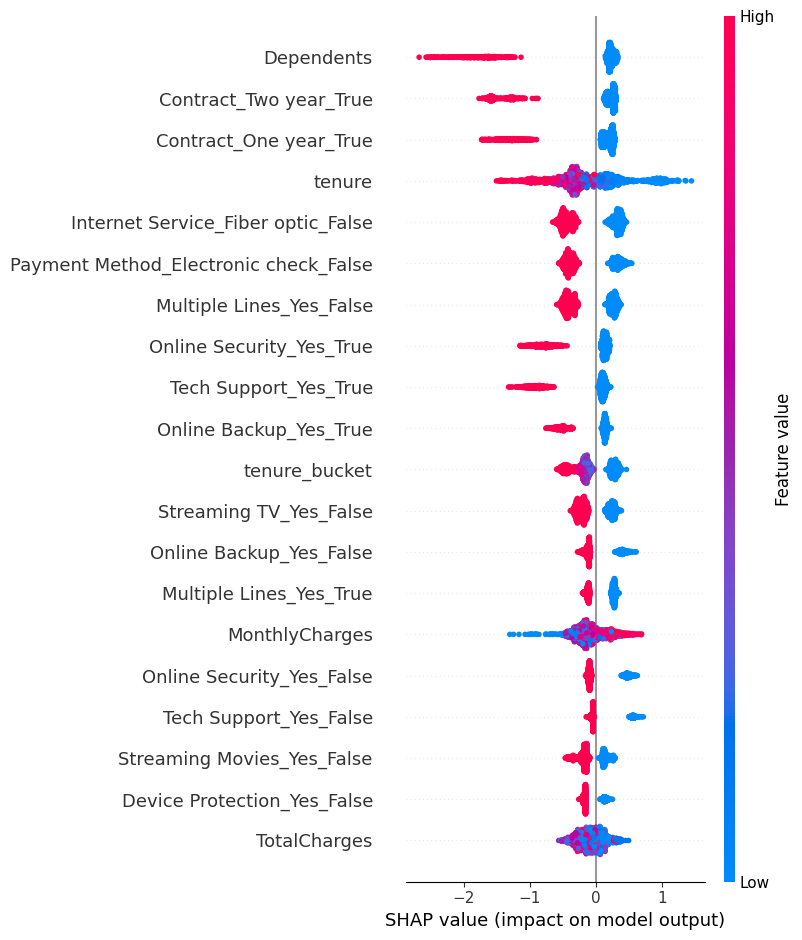

In [25]:
explainer=shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

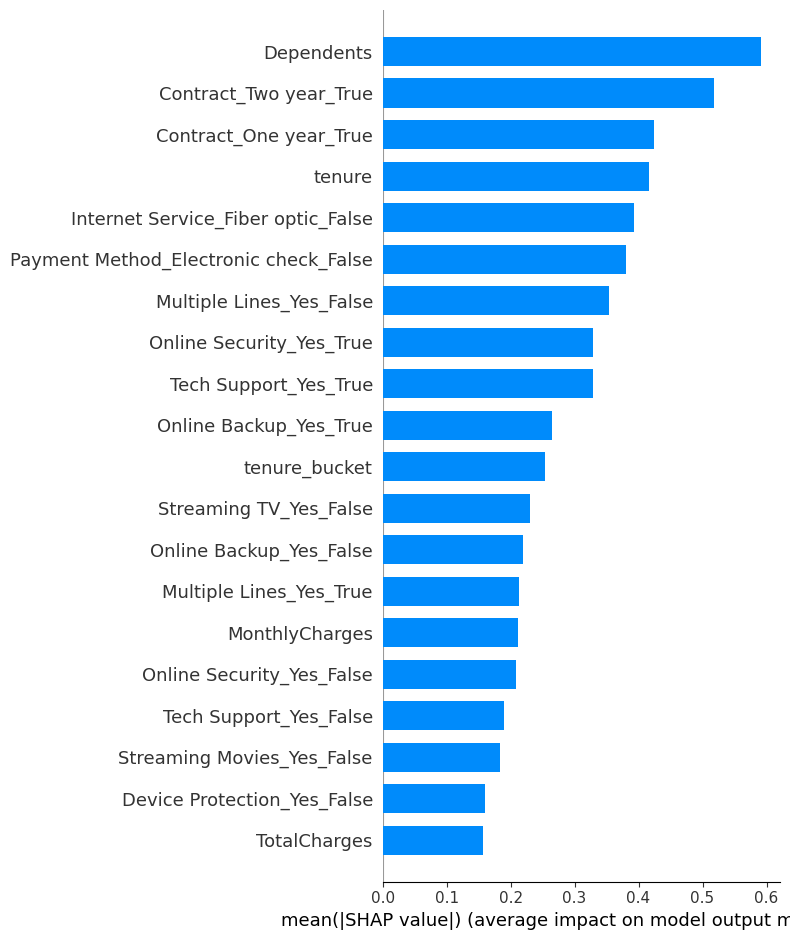

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [35]:
def log_odds_of_probability(log_odds):
    '''
    input: explainer's expected value
    output: probability of churning/not churning
    '''
    return 1/(1+np.exp(-log_odds))

shap.initjs()
for i in range (10):
    shap.force_plot(explainer.expected_value, shap_values[1], X_test.iloc[1])

    final_log_odds=explainer.expected_value+shap_values[i].sum()
    prob=log_odds_of_probability(final_log_odds)

    if final_log_odds>0:
        print(f"Prediction {i}: Model leans towards customer {i} churning with probability {100*prob:.4f}%")
    else:
        print(f"Prediction {i}: Model leans towards customer {i} not churning with probability {100*prob:.4f}%")

Prediction 0: Model leans towards customer 0 not churning with probability 1.5886%
Prediction 1: Model leans towards customer 1 churning with probability 68.7289%
Prediction 2: Model leans towards customer 2 not churning with probability 7.0405%
Prediction 3: Model leans towards customer 3 not churning with probability 18.4978%
Prediction 4: Model leans towards customer 4 not churning with probability 24.8002%
Prediction 5: Model leans towards customer 5 churning with probability 63.2293%
Prediction 6: Model leans towards customer 6 not churning with probability 0.9582%
Prediction 7: Model leans towards customer 7 not churning with probability 23.3853%
Prediction 8: Model leans towards customer 8 churning with probability 83.3312%
Prediction 9: Model leans towards customer 9 not churning with probability 0.5969%


In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[11], X_test.iloc[11])

In [39]:
print(log_odds_of_probability(explainer.expected_value*shap_values[11].sum()))

0.61181617


What this means is:
With a negative value, the model predicts no churn, i.e pulls towards class 0, but as value is not that high, the prediction isn't very strong with only a 61% chance that the customer will not churn

Features like internet service and multiple lines pull prediction up towards class 1, but features like contract and tenure bucket pull it down towards class 0

In [42]:
mean_abs_shap=np.abs(shap_values).mean(axis=0)
importance_df=pd.DataFrame({
    'feature':X_test.columns,
    'mean_abs_shap':mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

result_path=Path.cwd().parent/"results"/"feature_importance.csv"
importance_df.to_csv(result_path, index=False)